<h1> Olympic Medal Win Prediction Model <h1/>

![](rings.png)

<h4> Importing Libraries and Data <h4/>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('teams.csv')
df.head()

,team,country,year,events,athletes,age,height,weight,medals,prev_medals,prev_3_medals
0,AFG,Afghanistan,1964,8,8,22.0,161.0,64.2,0,0.0,0.0
1,AFG,Afghanistan,1968,5,5,23.2,170.2,70.0,0,0.0,0.0
2,AFG,Afghanistan,1972,8,8,29.0,168.3,63.8,0,0.0,0.0
3,AFG,Afghanistan,1980,11,11,23.6,168.4,63.2,0,0.0,0.0
4,AFG,Afghanistan,2004,5,5,18.6,170.8,64.8,0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2144 entries, 0 to 2143
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   team           2144 non-null   object 
 1   country        2144 non-null   object 
 2   year           2144 non-null   int64  
 3   events         2144 non-null   int64  
 4   athletes       2144 non-null   int64  
 5   age            2144 non-null   float64
 6   height         2144 non-null   float64
 7   weight         2144 non-null   float64
 8   medals         2144 non-null   int64  
 9   prev_medals    2014 non-null   float64
 10  prev_3_medals  2014 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 184.4+ KB


<h3> Data Cleaning <h3/>

In [52]:
df = df[["team", "country", "year", "athletes", "age", "prev_medals", "medals"]]

In [53]:
df.head()

,team,country,year,athletes,age,prev_medals,medals
0,AFG,Afghanistan,1964,8,22.0,0.0,0
1,AFG,Afghanistan,1968,5,23.2,0.0,0
2,AFG,Afghanistan,1972,8,29.0,0.0,0
3,AFG,Afghanistan,1980,11,23.6,0.0,0
4,AFG,Afghanistan,2004,5,18.6,0.0,0


In [54]:
df[df.isnull().any(axis=1)]
#We have around 130 missing rows with missing values in them

,team,country,year,athletes,age,prev_medals,medals


In [78]:
df.dropna(inplace = True)

<h3> Exploratory Data Analysis <h3/>

<AxesSubplot:>

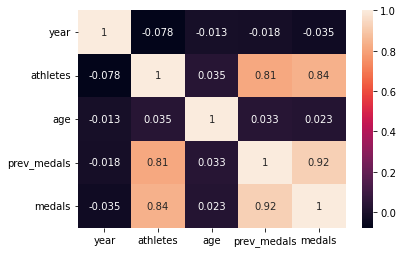

In [56]:
sns.heatmap(df.corr(), annot = True)

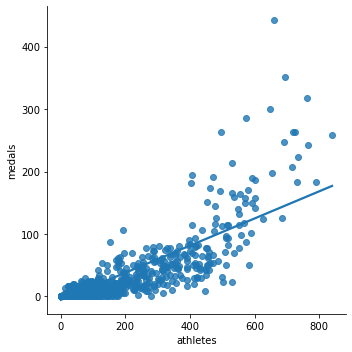

In [57]:
sns.lmplot(x='athletes', y = 'medals', data = df, ci = None, fit_reg = True)

<h3> splitting the data into a train and test dataset and training the model. <h3/>

In [79]:
train = df[df['year'] < 2012].copy()
test = df[df['year'] >= 2012].copy()

In [59]:
lm = LinearRegression()

In [60]:
predictors = ['athletes', 'prev_medals']
target = 'medals'

In [82]:
lm.fit(train[predictors], train['medals'])

LinearRegression()

In [62]:
predictions = lm.predict(test[predictors])
#Some of these predictions are negative which is not desired. 

<h3> Fixing the negative prediction problem <h3/>

In [63]:
test['predictions'] = predictions
test.head()

,team,country,year,athletes,age,prev_medals,medals,predictions
6,AFG,Afghanistan,2012,6,24.8,1.0,1,-0.961221
7,AFG,Afghanistan,2016,3,24.7,1.0,0,-1.176333
24,ALB,Albania,2012,10,25.7,0.0,0,-1.425032
25,ALB,Albania,2016,6,23.7,0.0,0,-1.711847
37,ALG,Algeria,2012,39,24.8,2.0,1,2.155629


In [64]:
test.loc[test['predictions'] < 0 , 'predictions'] = 0

In [65]:
test['predictions'] = test['predictions'].round()

<h3> Testing the model using error metrics <h3/>

In [66]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(test['medals'], test['predictions'])
print('MEAN ABSOLUTE ERROR = ', error)
#the MSE is below the standard deviation for the medals column

MEAN ABSOLUTE ERROR =  3.2987654320987656


In [83]:
errors = (test['medals']  - predictions).abs()

In [84]:
print(errors)

6       1.961221
7       1.176333
24      1.425032
25      1.711847
37      1.155629
          ...   
2111    1.926958
2131    1.640143
2132    1.640143
2142    1.505767
2143    0.080748
Name: medals, Length: 405, dtype: float64


In [91]:
error_by_team = errors.groupby(test['team']).mean()
medals_by_team = test['medals'].groupby(test['team']).mean()
error_ratio = error_by_team / medals_by_team

In [92]:
error_ratio[~pd.isnull(error_ratio)]

team
AFG    3.137554
ALB         inf
ALG    1.023422
AND         inf
ANG         inf
         ...   
VIE    1.231905
VIN         inf
YEM         inf
ZAM         inf
ZIM         inf
Name: medals, Length: 204, dtype: float64

In [93]:
error_ratio = error_ratio[np.isfinite(error_ratio)]

In [94]:
error_ratio

team
AFG    3.137554
ALG    1.023422
ARG    0.841636
ARM    0.433824
AUS    0.362901
         ...   
UKR    0.946412
USA    0.128207
UZB    0.658187
VEN    1.710208
VIE    1.231905
Name: medals, Length: 97, dtype: float64

<AxesSubplot:ylabel='Frequency'>

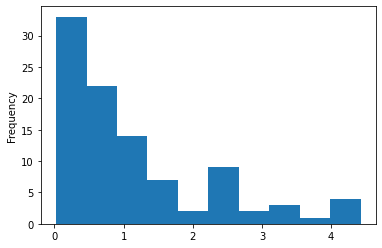

In [95]:
error_ratio.plot.hist()

<h2> Wrap up: <h2/>

The error ratio histogram shows that the variance of the error terms is significant, however this does not mean that the model is not useful. This prediction model is better fitted for some countries moreso than others. For example, the predictions for countries who send a greater number of athletes and have more medal wins in the past is more accurate compared to countries with low participation and success. 